In [1]:
# CELL 1: INSTALL DEPENDENCIES
# Run this first to install all required packages
# ==============================================================================

!pip install -q torch torchvision torchaudio
!pip install -q opencv-python matplotlib seaborn pandas pillow pyyaml
!pip install -q kaggle

print("✓ All dependencies installed successfully!")


✓ All dependencies installed successfully!


In [2]:
# CELL 2: SETUP KAGGLE AND DOWNLOAD DATASET
# Upload your kaggle.json file when prompted
# ==============================================================================

import os
from pathlib import Path

# For Google Colab
try:
    from google.colab import files
    print("Please upload your kaggle.json file:")
    uploaded = files.upload()
except:
    print("Not running in Colab - make sure kaggle.json is in ~/.kaggle/")

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ 2>/dev/null || echo "kaggle.json already in place"
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d pkdarabi/cardetection -p traffic_dataset --unzip

print("✓ Dataset downloaded!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/pkdarabi/cardetection
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/99.8M [00:00<?, ?B/s]
100% 99.8M/99.8M [00:00<00:00, 1.70GB/s]
✓ Dataset downloaded!


In [3]:
# CELL 3: CLONE YOLOV5 REPOSITORY
# ==============================================================================

import os

if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5
    %cd yolov5
    !pip install -q -r requirements.txt
    %cd ..
else:
    print('YOLOv5 already cloned')

print("✓ YOLOv5 ready!")

Cloning into 'yolov5'...
remote: Enumerating objects: 17757, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 17757 (delta 73), reused 39 (delta 39), pack-reused 17639 (from 4)
Receiving objects: 100% (17757/17757), 17.15 MiB | 31.87 MiB/s, done.
Resolving deltas: 100% (12055/12055), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.3 MB/s eta 0:00:00
/content
✓ YOLOv5 ready!


In [4]:
# CELL 4: VERIFY DATASET STRUCTURE
# ==============================================================================

from pathlib import Path

# Find dataset in environment
base = Path('traffic_dataset')

# Check if train exists directly
if not (base / 'train').exists():
    # Search for train folder
    for item in Path('.').glob('**/train'):
        if 'yolov5' not in str(item):
            base = item.parent
            break

print("\n" + "="*60)
print("DATASET STRUCTURE VERIFICATION")
print("="*60)
print(f"Dataset location: {base}")
print(f"Path exists: {base.exists()}")

# Count images
train_images = list((base/'train'/'images').glob('*.jpg')) + list((base/'train'/'images').glob('*.png'))
valid_images = list((base/'valid'/'images').glob('*.jpg')) + list((base/'valid'/'images').glob('*.png'))
test_images = list((base/'test'/'images').glob('*.jpg')) + list((base/'test'/'images').glob('*.png'))

print(f"\nTrain images: {len(train_images)} files")
print(f"Valid images: {len(valid_images)} files")
print(f"Test images: {len(test_images)} files")

# Count labels
train_labels = list((base/'train'/'labels').glob('*.txt'))
valid_labels = list((base/'valid'/'labels').glob('*.txt'))
test_labels = list((base/'test'/'labels').glob('*.txt'))

print(f"\nTrain labels: {len(train_labels)} files")
print(f"Valid labels: {len(valid_labels)} files")
print(f"Test labels: {len(test_labels)} files")
print("="*60)


DATASET STRUCTURE VERIFICATION
Dataset location: traffic_dataset/car
Path exists: True

Train images: 3530 files
Valid images: 801 files
Test images: 638 files

Train labels: 3530 files
Valid labels: 801 files
Test labels: 638 files


In [5]:
# CELL 5: CREATE DATA.YAML CONFIGURATION
# ==============================================================================

import yaml

# 15 traffic sign classes as per the paper
classes = [
    'Green Light',
    'Red Light',
    'Speed Limit 10',
    'Speed Limit 100',
    'Speed Limit 110',
    'Speed Limit 120',
    'Speed Limit 20',
    'Speed Limit 30',
    'Speed Limit 40',
    'Speed Limit 50',
    'Speed Limit 60',
    'Speed Limit 70',
    'Speed Limit 80',
    'Speed Limit 90',
    'Stop'
]

# Create data.yaml with absolute paths
data_yaml = {
    'path': str(base.resolve()),
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': len(classes),
    'names': classes
}

# Save to file
with open('traffic_data.yaml', 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print("\n✓ Created traffic_data.yaml:")
print("="*60)
print(yaml.dump(data_yaml, default_flow_style=False))
print("="*60)



✓ Created traffic_data.yaml:
names:
- Green Light
- Red Light
- Speed Limit 10
- Speed Limit 100
- Speed Limit 110
- Speed Limit 120
- Speed Limit 20
- Speed Limit 30
- Speed Limit 40
- Speed Limit 50
- Speed Limit 60
- Speed Limit 70
- Speed Limit 80
- Speed Limit 90
- Stop
nc: 15
path: /content/traffic_dataset/car
test: test/images
train: train/images
val: valid/images



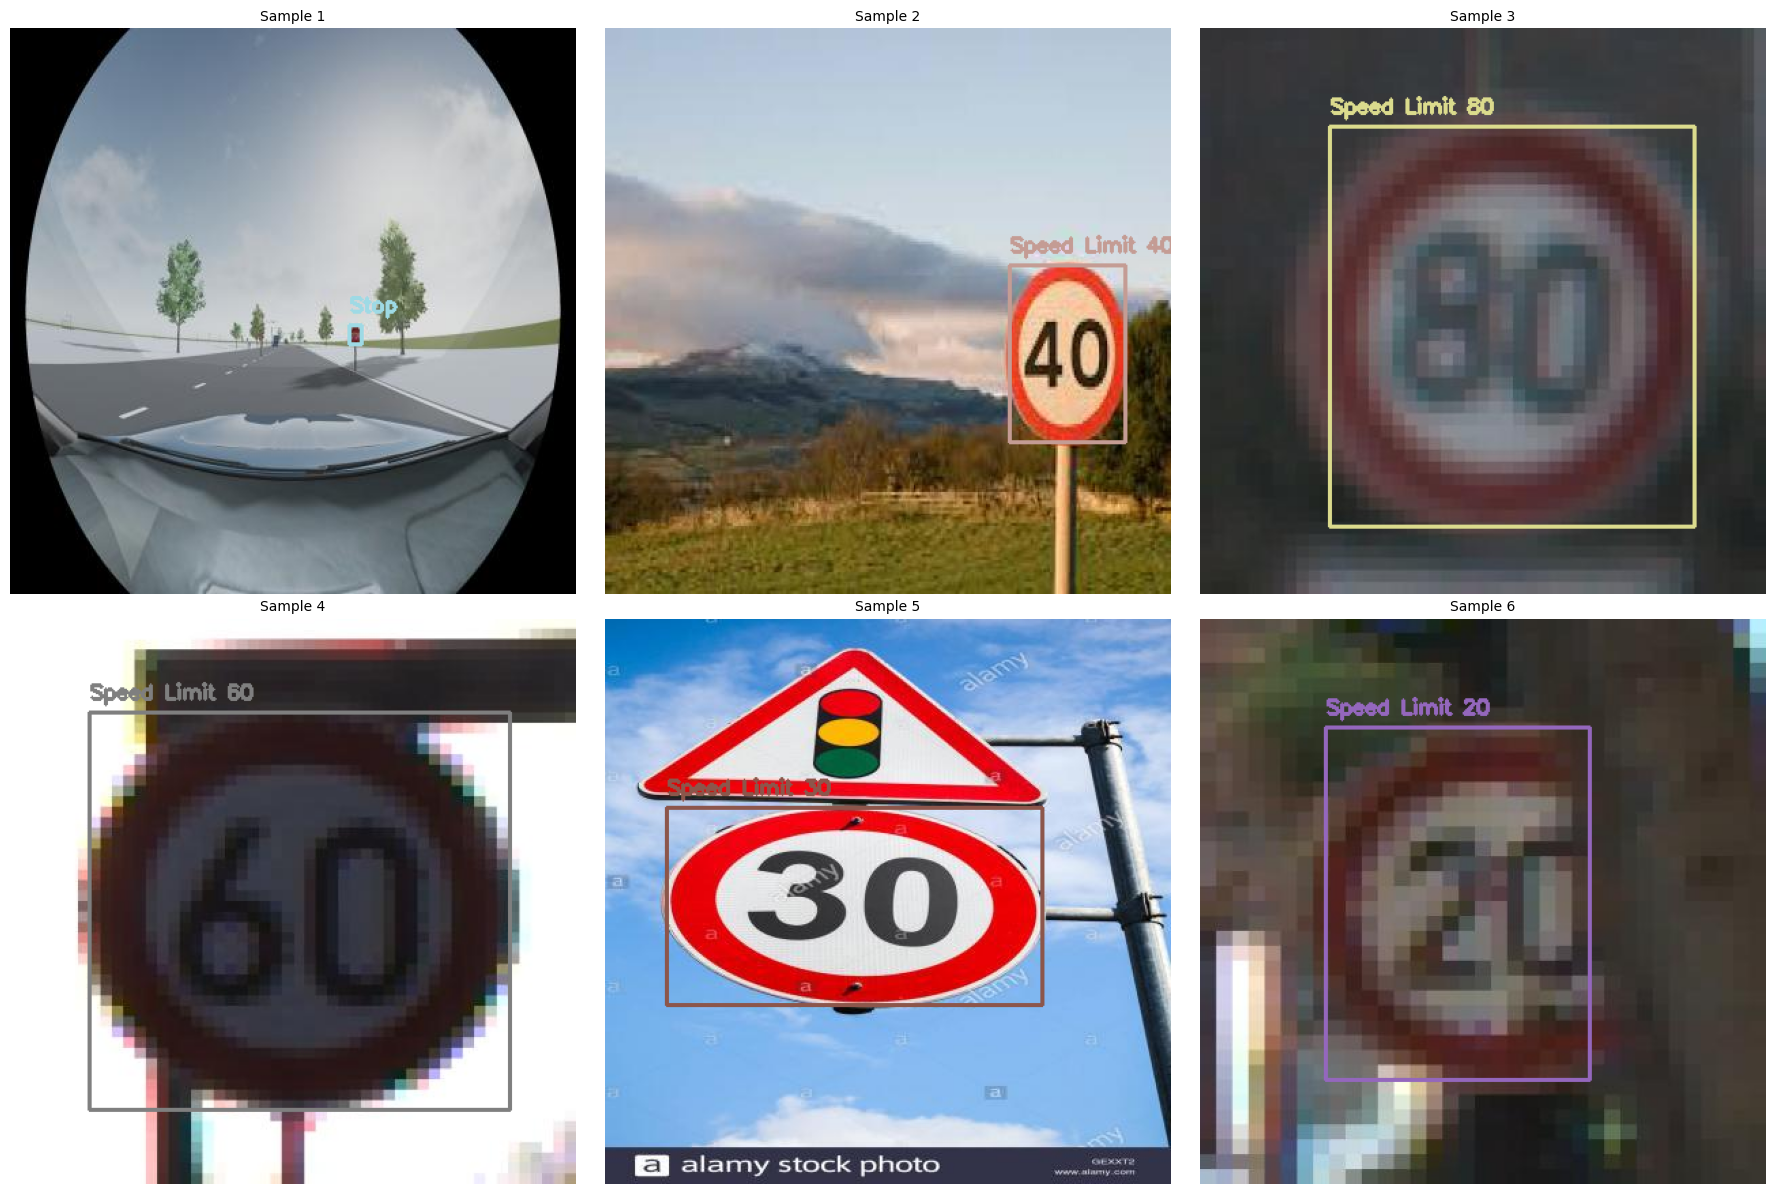

✓ Sample visualizations saved!


In [6]:
# CELL 6: VISUALIZE SAMPLE IMAGES WITH BOUNDING BOXES
# ==============================================================================

import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(dataset_path, num_samples=6):
    """Visualize random training samples with bounding boxes"""

    train_img_path = Path(dataset_path) / 'train' / 'images'
    train_lbl_path = Path(dataset_path) / 'train' / 'labels'

    image_files = list(train_img_path.glob('*.jpg'))
    if len(image_files) == 0:
        image_files = list(train_img_path.glob('*.png'))

    if len(image_files) == 0:
        print("No images found!")
        return

    image_files = image_files[:num_samples]

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    colors = plt.cm.tab20(np.linspace(0, 1, len(classes)))

    for idx, img_path in enumerate(image_files):
        # Read image
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Read corresponding label
        label_path = train_lbl_path / (img_path.stem + '.txt')
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id, x_center, y_center, width, height = map(float, parts[:5])

                        # Convert from normalized to pixel coordinates
                        x1 = int((x_center - width/2) * w)
                        y1 = int((y_center - height/2) * h)
                        x2 = int((x_center + width/2) * w)
                        y2 = int((y_center + height/2) * h)

                        # Draw bounding box
                        class_id = int(class_id)
                        if class_id < len(classes):
                            color = (np.array(colors[class_id][:3]) * 255).astype(int)
                            cv2.rectangle(img, (x1, y1), (x2, y2), color.tolist(), 2)
                            cv2.putText(img, classes[class_id], (x1, y1-10),
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        axes[idx].imshow(img)
        axes[idx].set_title(f"Sample {idx+1}", fontsize=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('sample_visualizations.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Sample visualizations saved!")

visualize_samples(base)

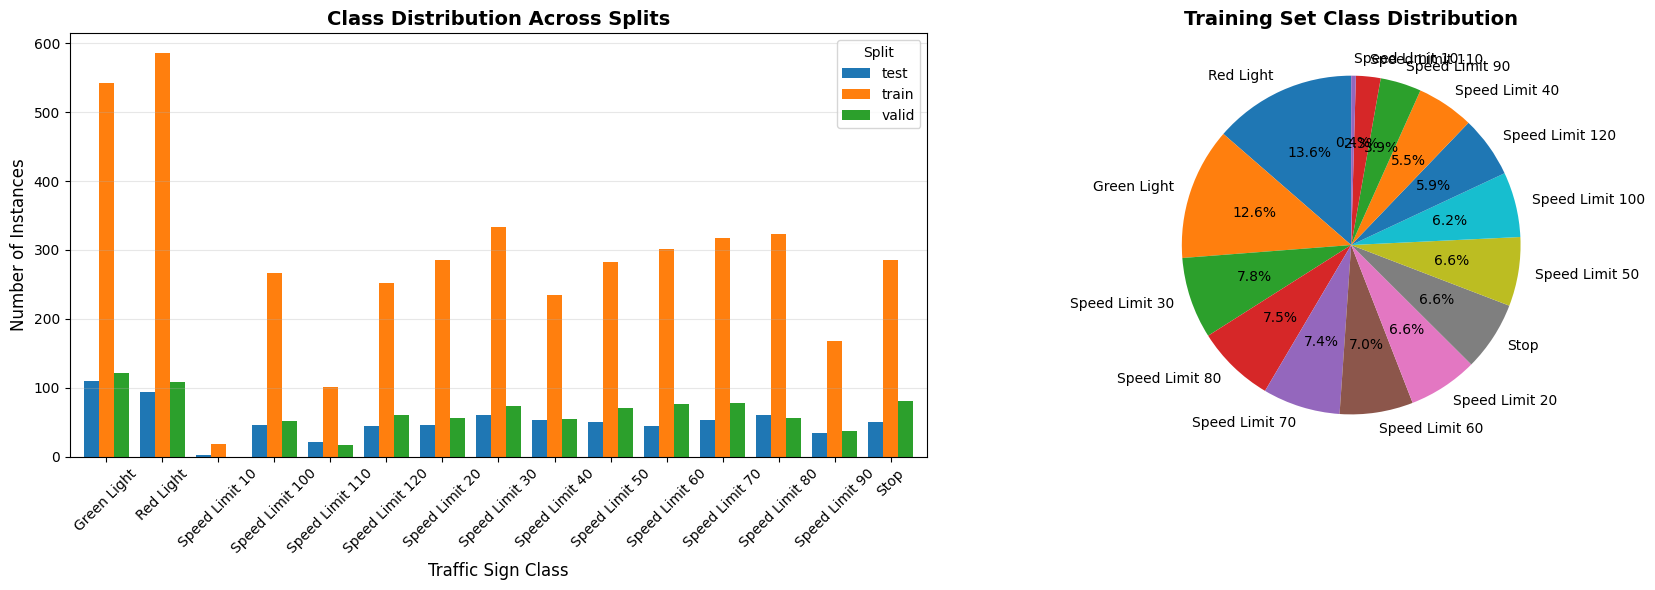


CLASS DISTRIBUTION STATISTICS

TRAIN Split:
  Total instances: 4298
  Unique classes: 15

VALID Split:
  Total instances: 944
  Unique classes: 14

TEST Split:
  Total instances: 770
  Unique classes: 15

✅ PHASE 1 COMPLETE - Dataset Preparation Done!


In [7]:
# CELL 7: ANALYZE CLASS DISTRIBUTION
# ==============================================================================

import pandas as pd
from collections import Counter
import seaborn as sns

def analyze_class_distribution(dataset_path):
    """Analyze and visualize class distribution across splits"""

    splits = ['train', 'valid', 'test']
    all_stats = {}

    for split in splits:
        label_path = Path(dataset_path) / split / 'labels'

        class_counts = Counter()
        total_boxes = 0

        for label_file in label_path.glob('*.txt'):
            with open(label_file, 'r') as f:
                for line in f.readlines():
                    parts = line.split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        if class_id < len(classes):
                            class_counts[class_id] += 1
                            total_boxes += 1

        all_stats[split] = {
            'counts': class_counts,
            'total': total_boxes
        }

    # Create DataFrame
    data_rows = []
    for split, stats in all_stats.items():
        for class_id, count in stats['counts'].items():
            data_rows.append({
                'Split': split,
                'Class': classes[class_id],
                'Count': count
            })

    df = pd.DataFrame(data_rows)

    if len(df) == 0:
        print("No data found!")
        return df

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Bar plot by split
    pivot_df = df.pivot(index='Class', columns='Split', values='Count').fillna(0)
    pivot_df.plot(kind='bar', ax=axes[0], width=0.8)
    axes[0].set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Traffic Sign Class', fontsize=12)
    axes[0].set_ylabel('Number of Instances', fontsize=12)
    axes[0].legend(title='Split')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)

    # Pie chart for train split
    train_data = df[df['Split'] == 'train'].sort_values('Count', ascending=False)
    if len(train_data) > 0:
        axes[1].pie(train_data['Count'], labels=train_data['Class'], autopct='%1.1f%%',
                    startangle=90)
        axes[1].set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print statistics
    print("\n" + "="*60)
    print("CLASS DISTRIBUTION STATISTICS")
    print("="*60)
    for split, stats in all_stats.items():
        print(f"\n{split.upper()} Split:")
        print(f"  Total instances: {stats['total']}")
        print(f"  Unique classes: {len(stats['counts'])}")
    print("="*60)

    return df

dist_df = analyze_class_distribution(base)
print("\n✅ PHASE 1 COMPLETE - Dataset Preparation Done!")

In [8]:
# CELL 8: CHECK SYSTEM ENVIRONMENT
# ==============================================================================

import torch
import time

print("="*60)
print("SYSTEM INFORMATION")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("Running on CPU (training will be slower)")
print("="*60)


SYSTEM INFORMATION
PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB
CUDA version: 12.6


In [9]:
# CELL 9: TRAIN YOLOV5 MODEL
# Note: Using 20 epochs for faster training. For best results use 40-60 epochs
# ==============================================================================

print("\nStarting YOLOv5 Training...")
print("="*60)

start_time = time.time()

# Training configuration
!python yolov5/train.py \
    --img 640 \
    --batch 16 \
    --epochs 60 \
    --data traffic_data.yaml \
    --weights yolov5s.pt \
    --project runs/train \
    --name traffic_yolov5s_exp \
    --patience 5 \
    --cache

training_time = time.time() - start_time

print("\n" + "="*60)
print(f"✓ Training completed in {training_time/60:.2f} minutes!")
print("="*60)


Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
      48/59      4.45G    0.01933   0.005707     0.0102         42        640:  89% 196/221 [00:15<00:01, 12.63it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      48/59      4.45G    0.01934   0.005712     0.0102         46        640:  89% 196/221 [00:15<00:01, 12.63it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      48/59      4.45G    0.01933   0.005702    0.01021         29        640:  90% 198/221 [00:16<00:01, 12.50it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(

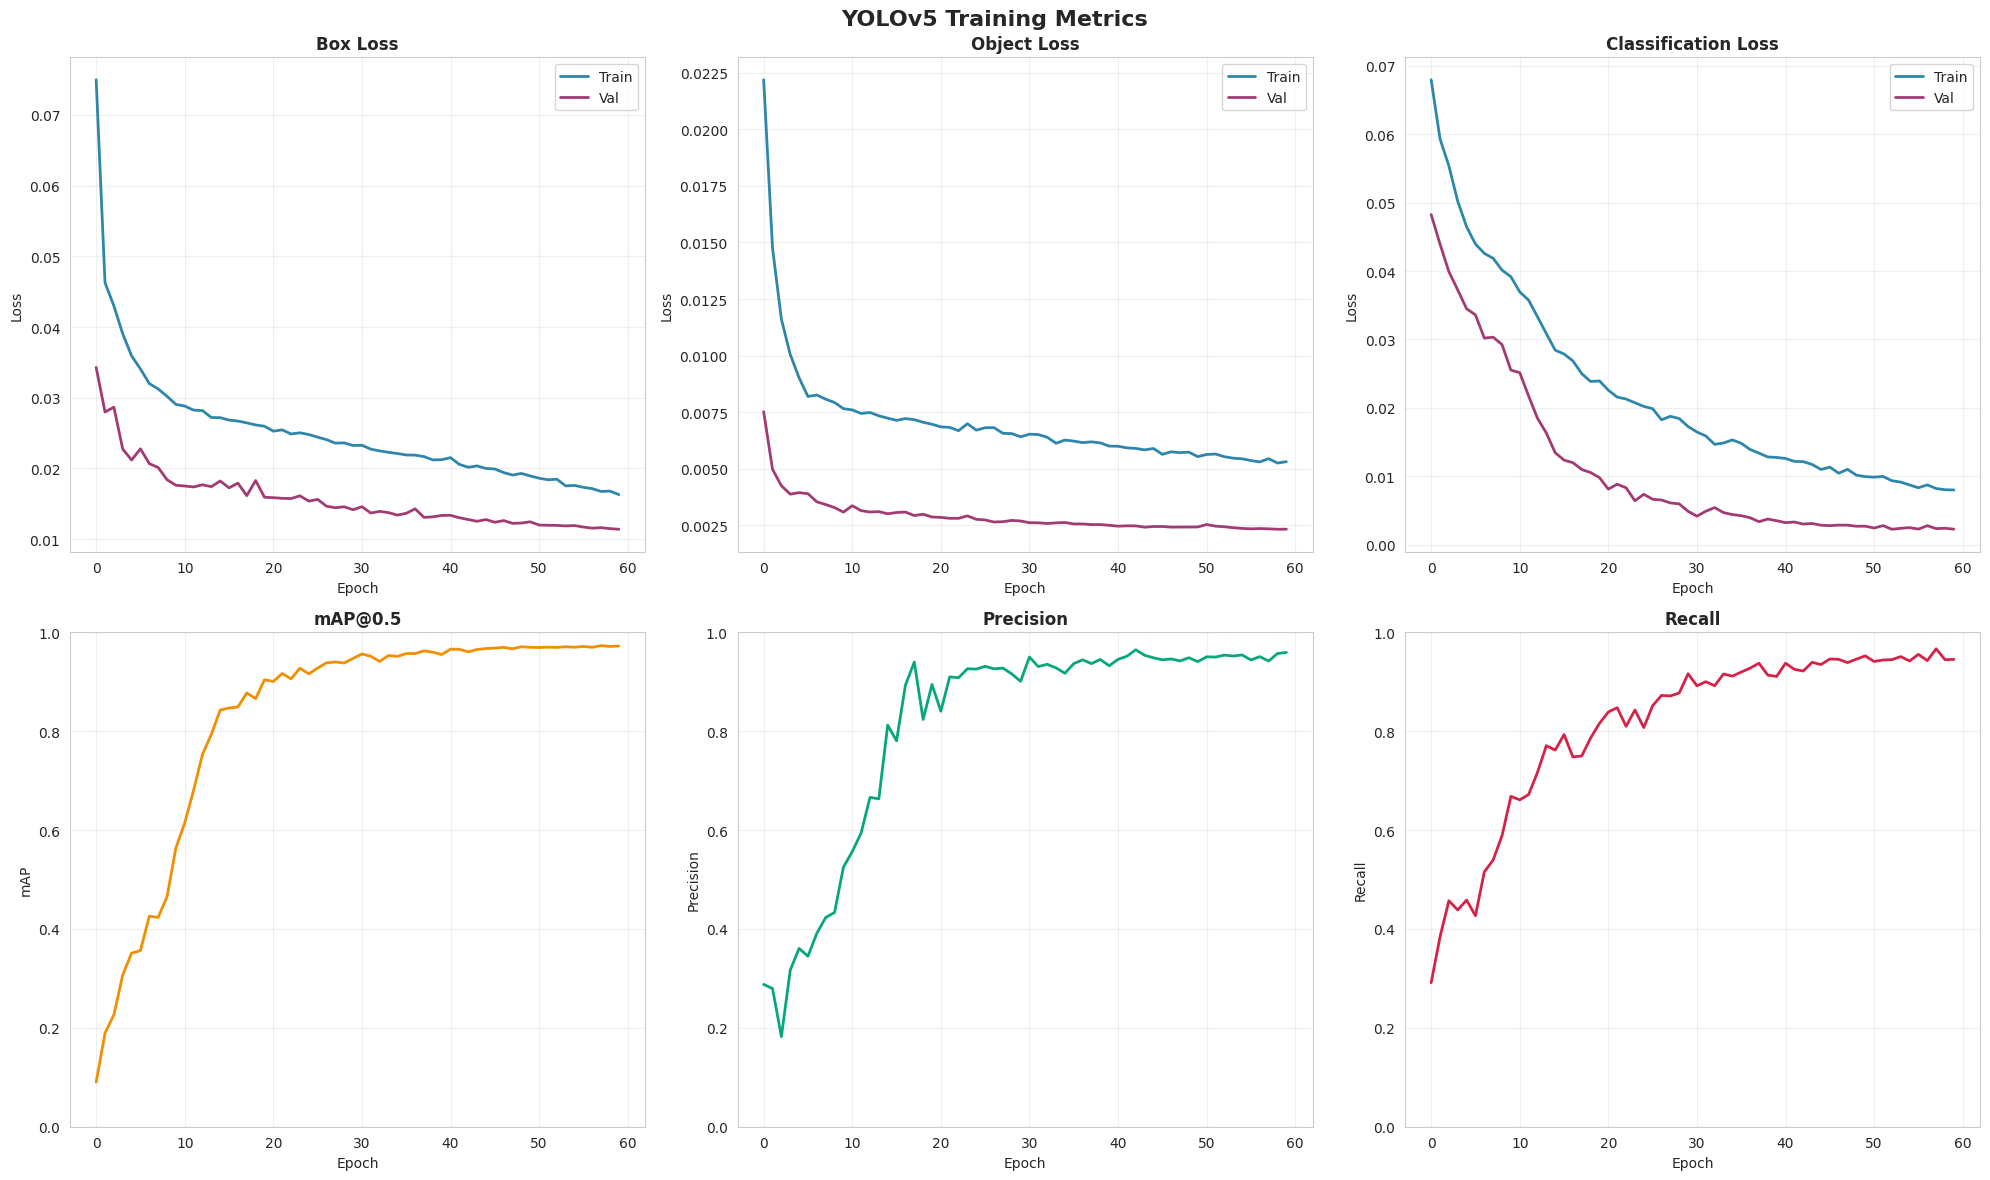


FINAL TRAINING METRICS
mAP@0.5:      0.9723
mAP@0.5:0.95: 0.8276
Precision:    0.9593
Recall:       0.9453

✅ PHASE 2 COMPLETE - Training Done!


In [10]:
# CELL 10: VISUALIZE TRAINING METRICS
# ==============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

exp_path = Path('runs/train/traffic_yolov5s_exp')
results_file = exp_path / 'results.csv'

if results_file.exists():
    df = pd.read_csv(results_file)
    df.columns = df.columns.str.strip()

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('YOLOv5 Training Metrics', fontsize=16, fontweight='bold')

    epochs = range(len(df))

    # Box Loss
    if 'train/box_loss' in df.columns and 'val/box_loss' in df.columns:
        axes[0, 0].plot(epochs, df['train/box_loss'], label='Train', linewidth=2, color='#2E86AB')
        axes[0, 0].plot(epochs, df['val/box_loss'], label='Val', linewidth=2, color='#A23B72')
        axes[0, 0].set_title('Box Loss', fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)

    # Object Loss
    if 'train/obj_loss' in df.columns and 'val/obj_loss' in df.columns:
        axes[0, 1].plot(epochs, df['train/obj_loss'], label='Train', linewidth=2, color='#2E86AB')
        axes[0, 1].plot(epochs, df['val/obj_loss'], label='Val', linewidth=2, color='#A23B72')
        axes[0, 1].set_title('Object Loss', fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)

    # Class Loss
    if 'train/cls_loss' in df.columns and 'val/cls_loss' in df.columns:
        axes[0, 2].plot(epochs, df['train/cls_loss'], label='Train', linewidth=2, color='#2E86AB')
        axes[0, 2].plot(epochs, df['val/cls_loss'], label='Val', linewidth=2, color='#A23B72')
        axes[0, 2].set_title('Classification Loss', fontweight='bold')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Loss')
        axes[0, 2].legend()
        axes[0, 2].grid(alpha=0.3)

    # mAP@0.5
    map_col = 'metrics/mAP_0.5' if 'metrics/mAP_0.5' in df.columns else 'metrics/mAP50'
    if map_col in df.columns:
        axes[1, 0].plot(epochs, df[map_col], linewidth=2, color='#F18F01')
        axes[1, 0].set_title('mAP@0.5', fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('mAP')
        axes[1, 0].set_ylim([0, 1])
        axes[1, 0].grid(alpha=0.3)

    # Precision
    if 'metrics/precision' in df.columns:
        axes[1, 1].plot(epochs, df['metrics/precision'], linewidth=2, color='#06A77D')
        axes[1, 1].set_title('Precision', fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Precision')
        axes[1, 1].set_ylim([0, 1])
        axes[1, 1].grid(alpha=0.3)

    # Recall
    if 'metrics/recall' in df.columns:
        axes[1, 2].plot(epochs, df['metrics/recall'], linewidth=2, color='#D62246')
        axes[1, 2].set_title('Recall', fontweight='bold')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Recall')
        axes[1, 2].set_ylim([0, 1])
        axes[1, 2].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(exp_path / 'training_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print final metrics
    print("\n" + "="*60)
    print("FINAL TRAINING METRICS")
    print("="*60)
    last_row = df.iloc[-1]

    map50_col = 'metrics/mAP_0.5' if 'metrics/mAP_0.5' in df.columns else 'metrics/mAP50'
    map50_95_col = 'metrics/mAP_0.5:0.95' if 'metrics/mAP_0.5:0.95' in df.columns else 'metrics/mAP50-95'

    print(f"mAP@0.5:      {last_row.get(map50_col, 0):.4f}")
    print(f"mAP@0.5:0.95: {last_row.get(map50_95_col, 0):.4f}")
    print(f"Precision:    {last_row.get('metrics/precision', 0):.4f}")
    print(f"Recall:       {last_row.get('metrics/recall', 0):.4f}")
    print("="*60)
else:
    print("Results file not found!")

print("\n✅ PHASE 2 COMPLETE - Training Done!")


In [11]:
# CELL 11: EVALUATE MODEL ON TEST SET
# ==============================================================================

best_weights = Path('runs/train/traffic_yolov5s_exp/weights/best.pt')

if not best_weights.exists():
    print("❌ Best weights not found. Please run training first.")
else:
    print("="*60)
    print("RUNNING MODEL EVALUATION ON TEST SET")
    print("="*60)

    !python yolov5/val.py \
        --data traffic_data.yaml \
        --weights runs/train/traffic_yolov5s_exp/weights/best.pt \
        --img 640 \
        --batch 16 \
        --task test \
        --save-txt \
        --save-conf \
        --project runs/test \
        --name traffic_eval


RUNNING MODEL EVALUATION ON TEST SET
val: data=traffic_data.yaml, weights=['runs/train/traffic_yolov5s_exp/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=False, project=runs/test, name=traffic_eval, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-450-g781b9d57 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)

Fusing layers... 
Model summary: 157 layers, 7050580 parameters, 0 gradients, 15.9 GFLOPs
test: Scanning /content/traffic_dataset/car/test/labels... 638 images, 1 backgrounds, 0 corrupt: 100% 638/638 [00:00<00:00, 10570.76it/s]
test: New cache created: /content/traffic_dataset/car/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 40/40 [00:07<00:00,  5.50it/s]
                   all        638        770      0


EVALUATION VISUALIZATIONS

confusion_matrix.png found at: runs/test/traffic_eval/confusion_matrix.png


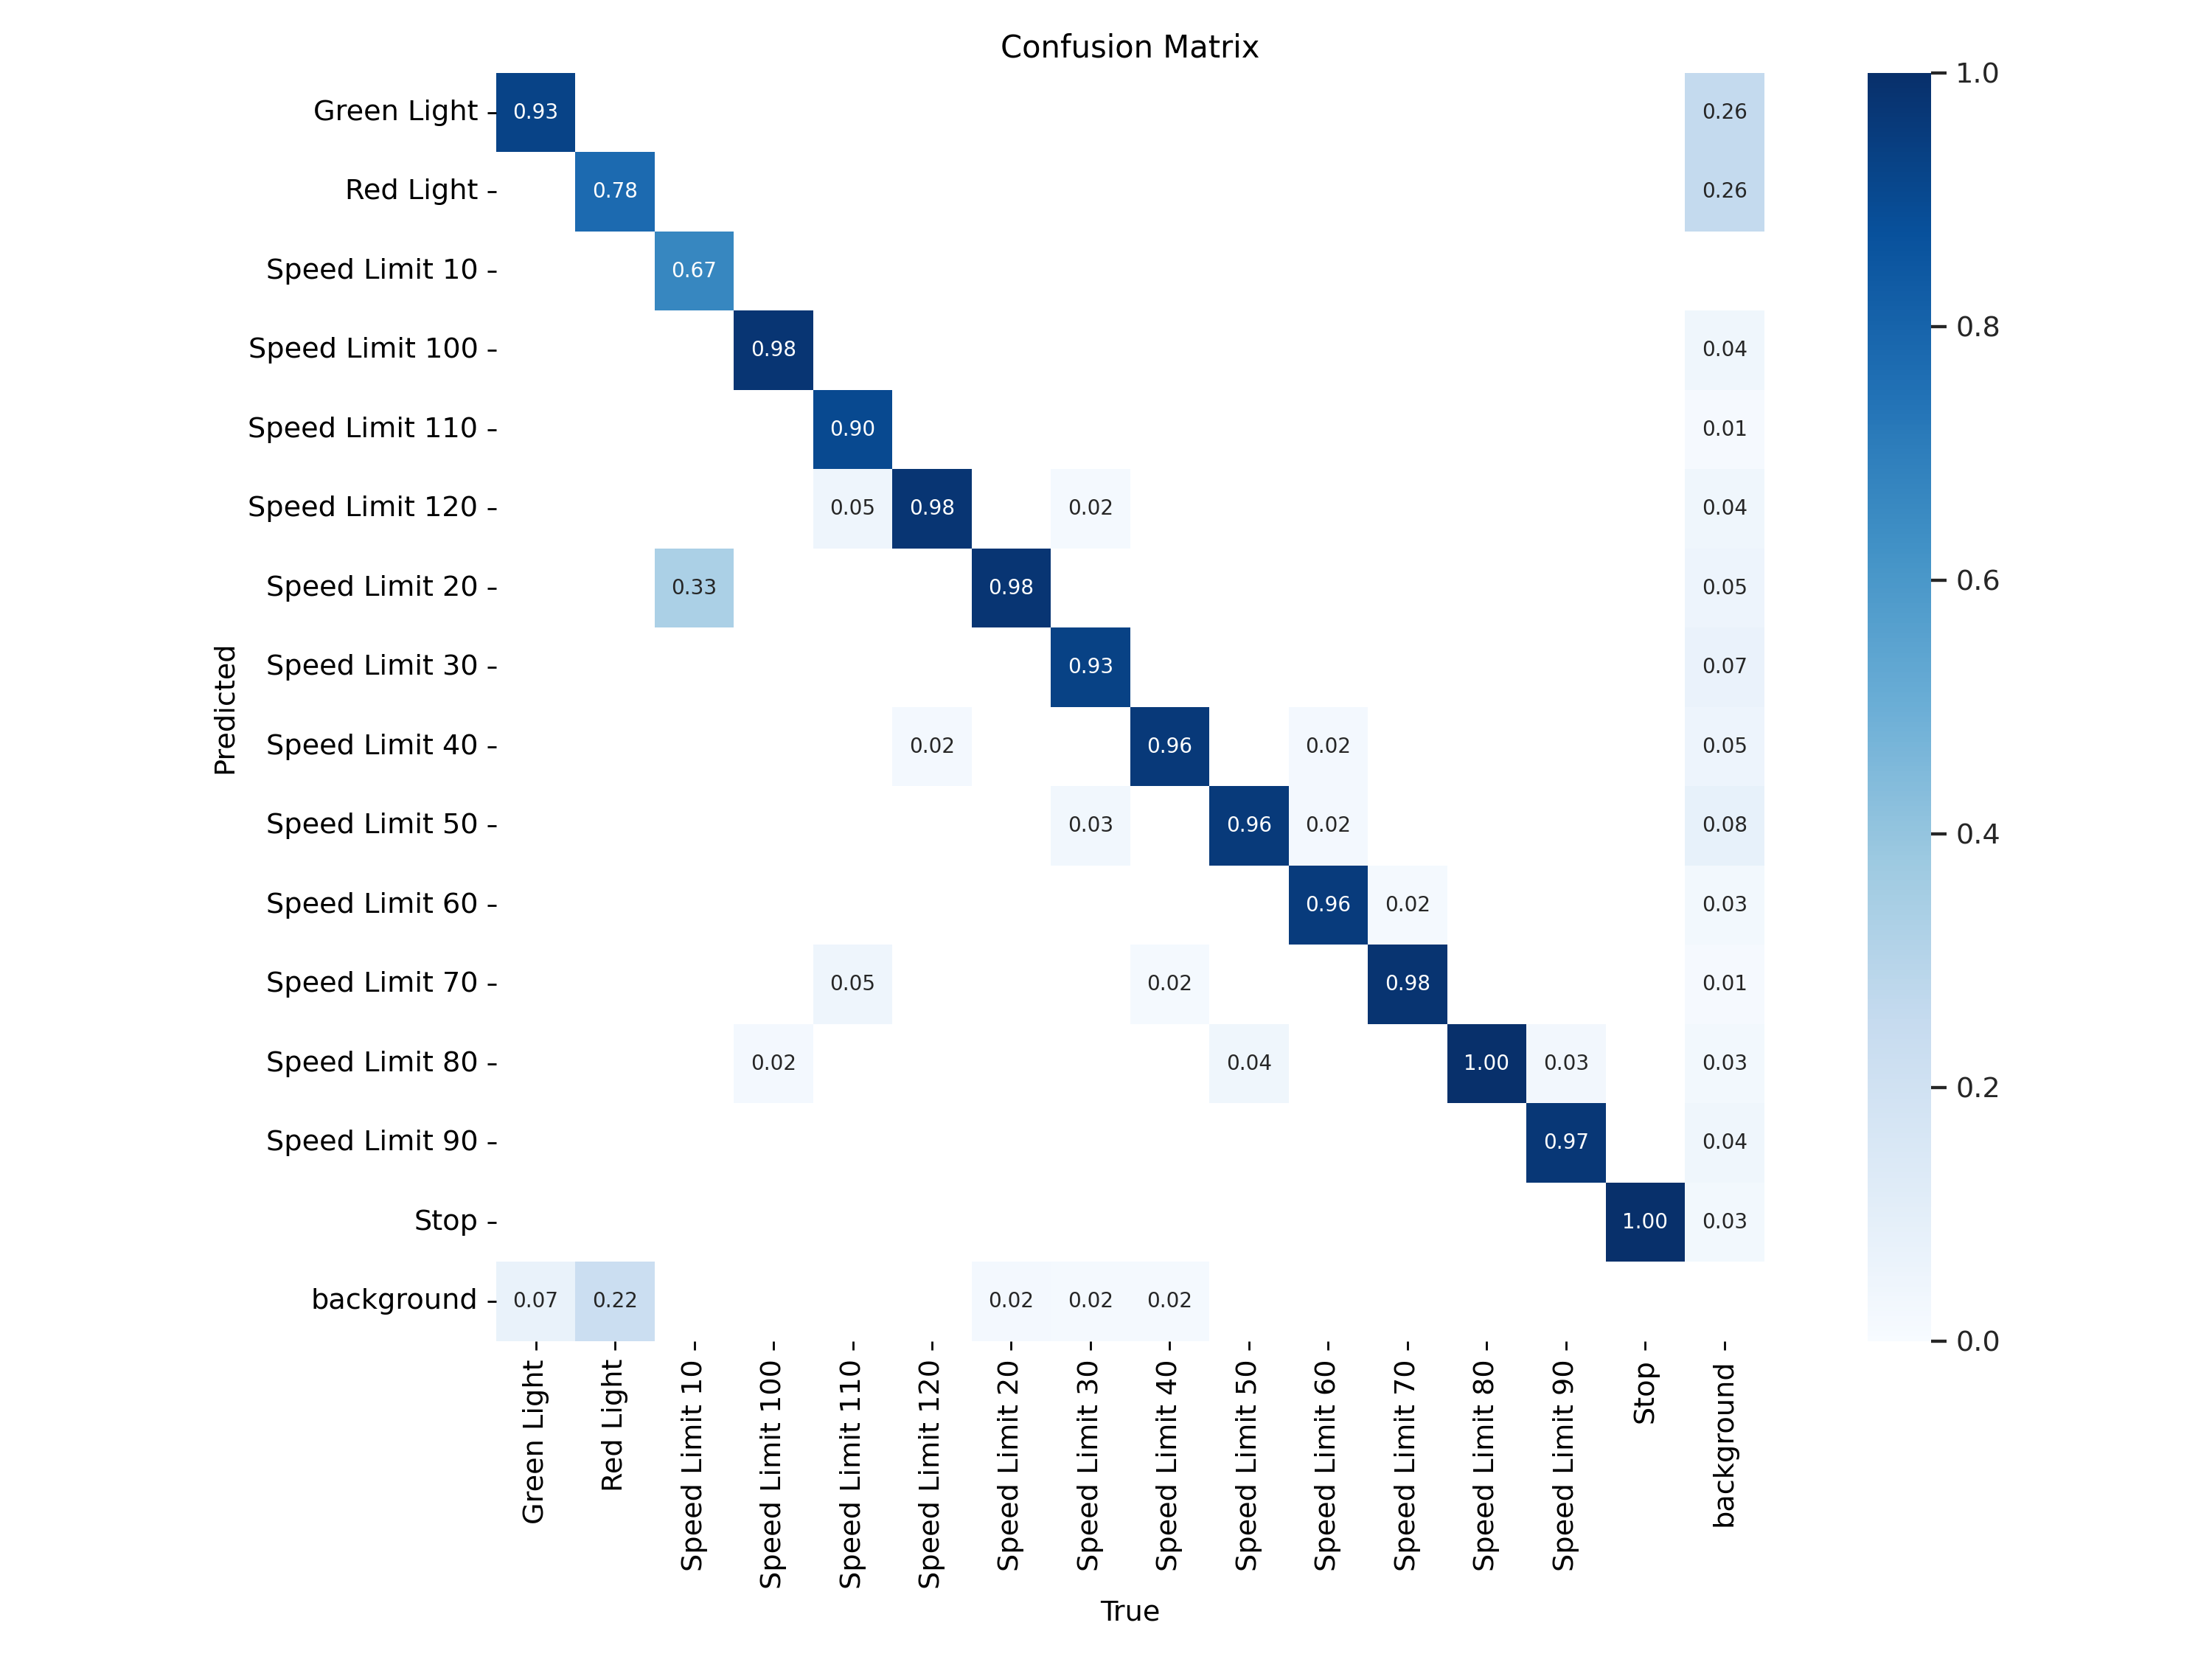


F1_curve.png found at: runs/test/traffic_eval/F1_curve.png


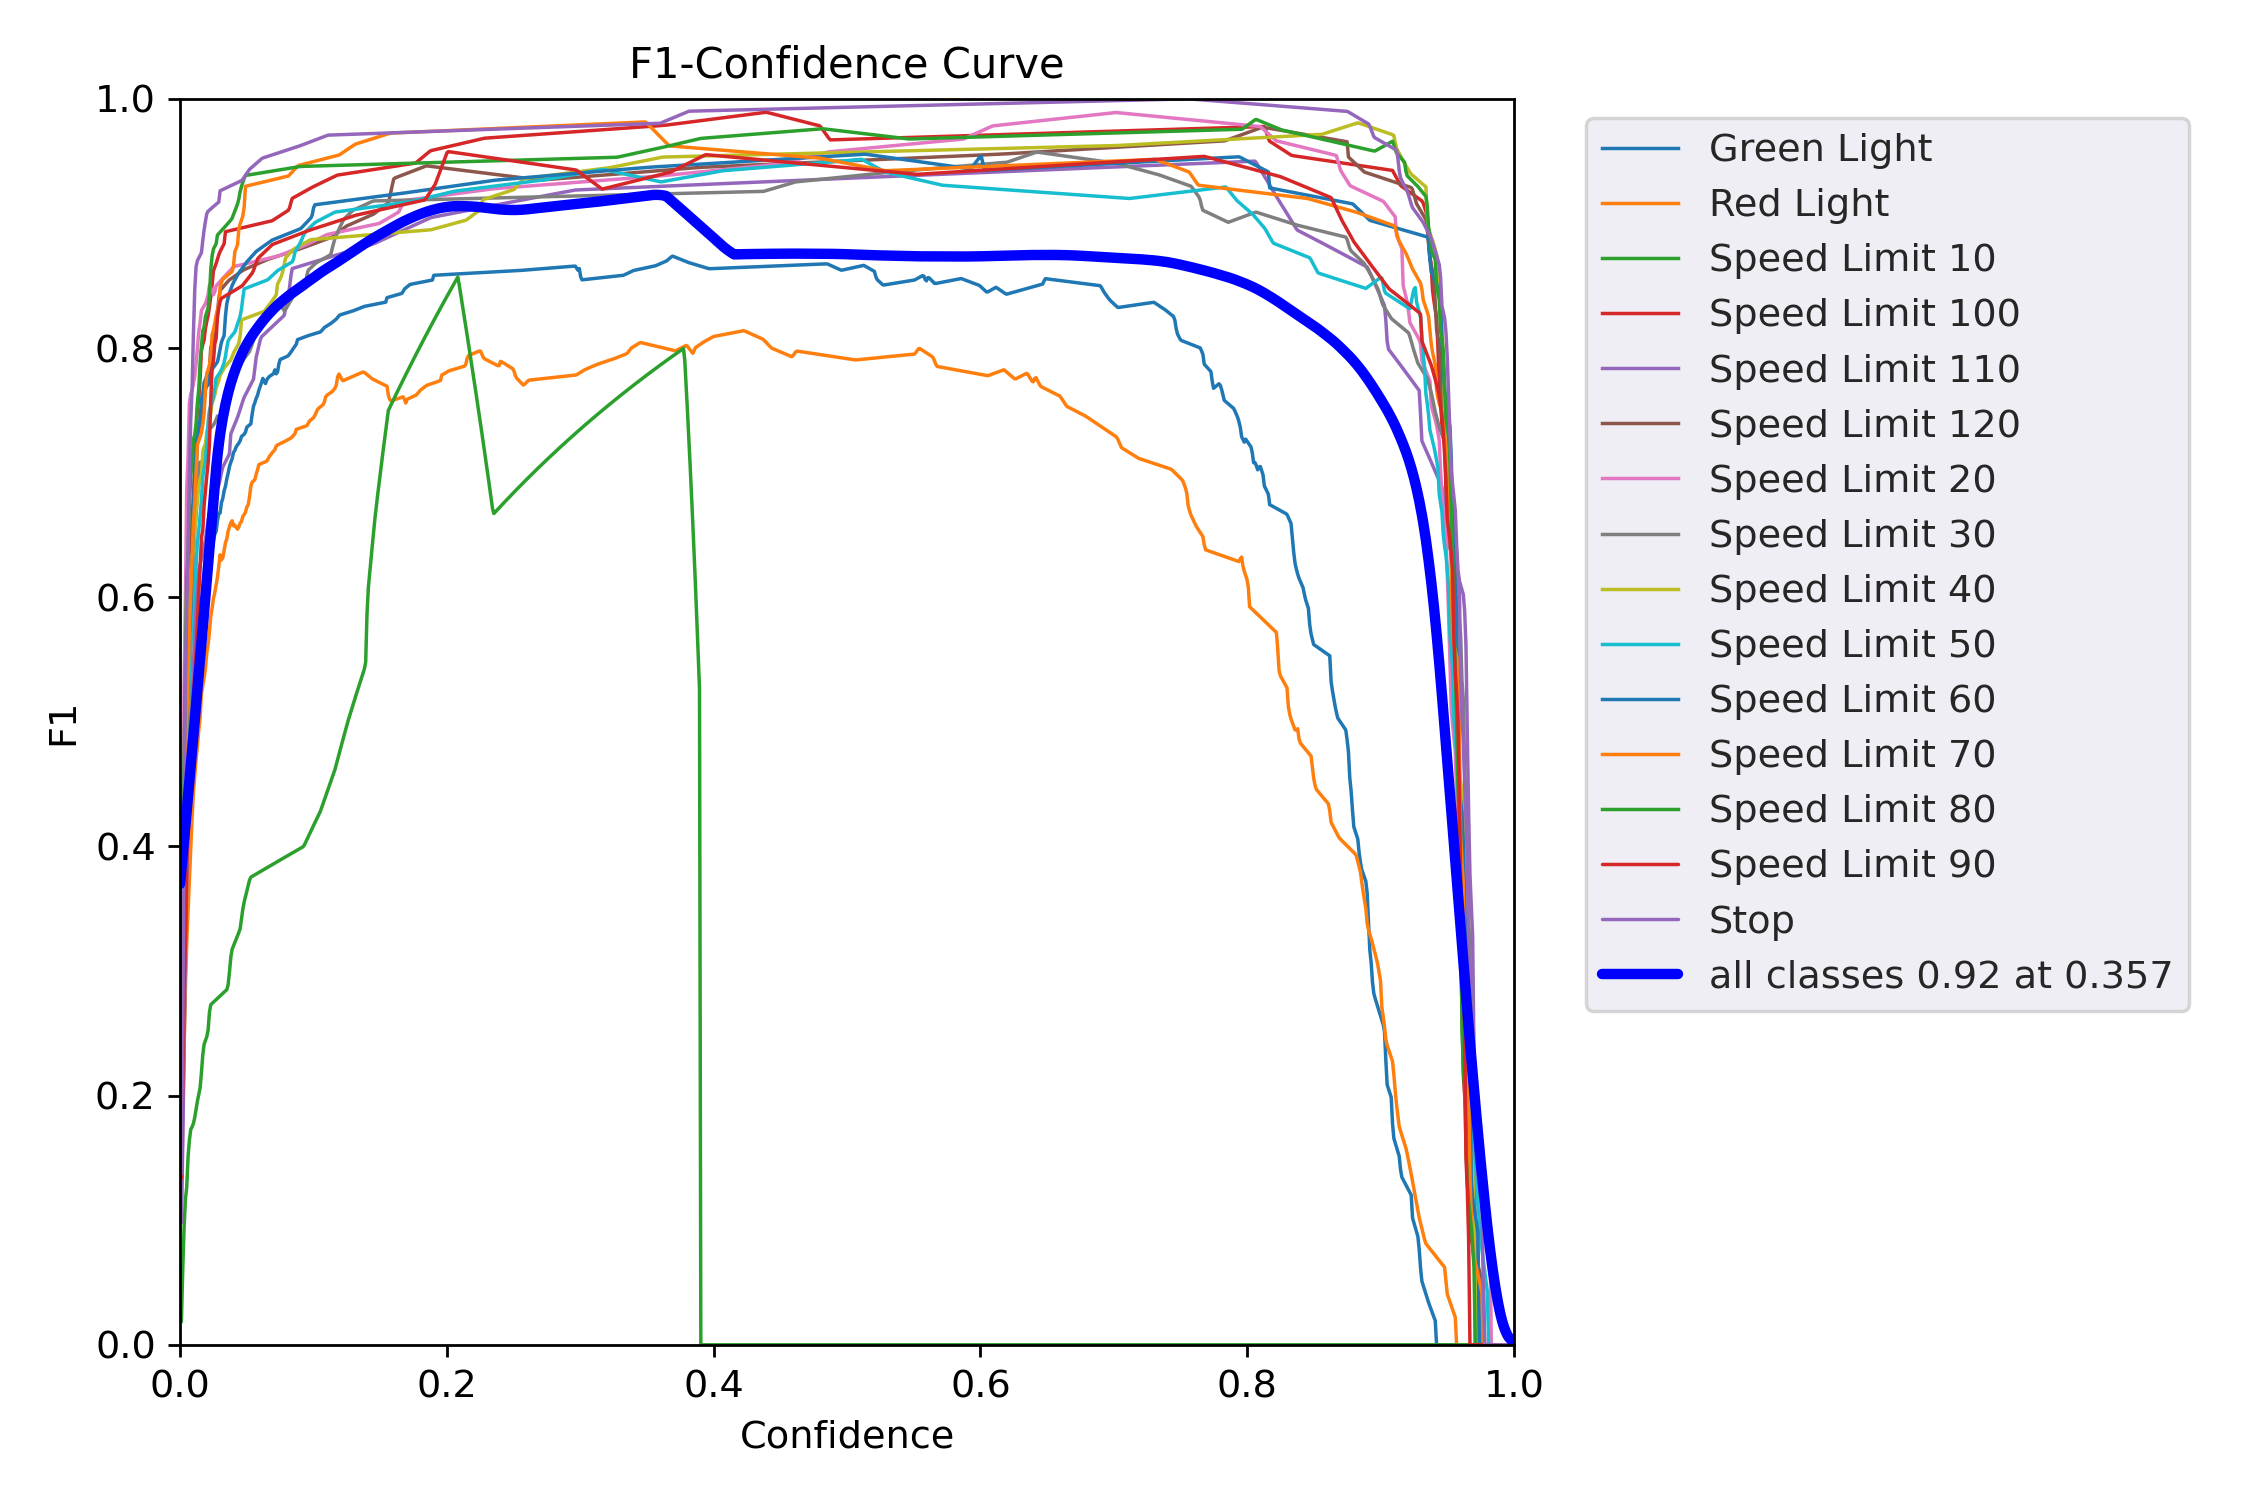


PR_curve.png found at: runs/test/traffic_eval/PR_curve.png


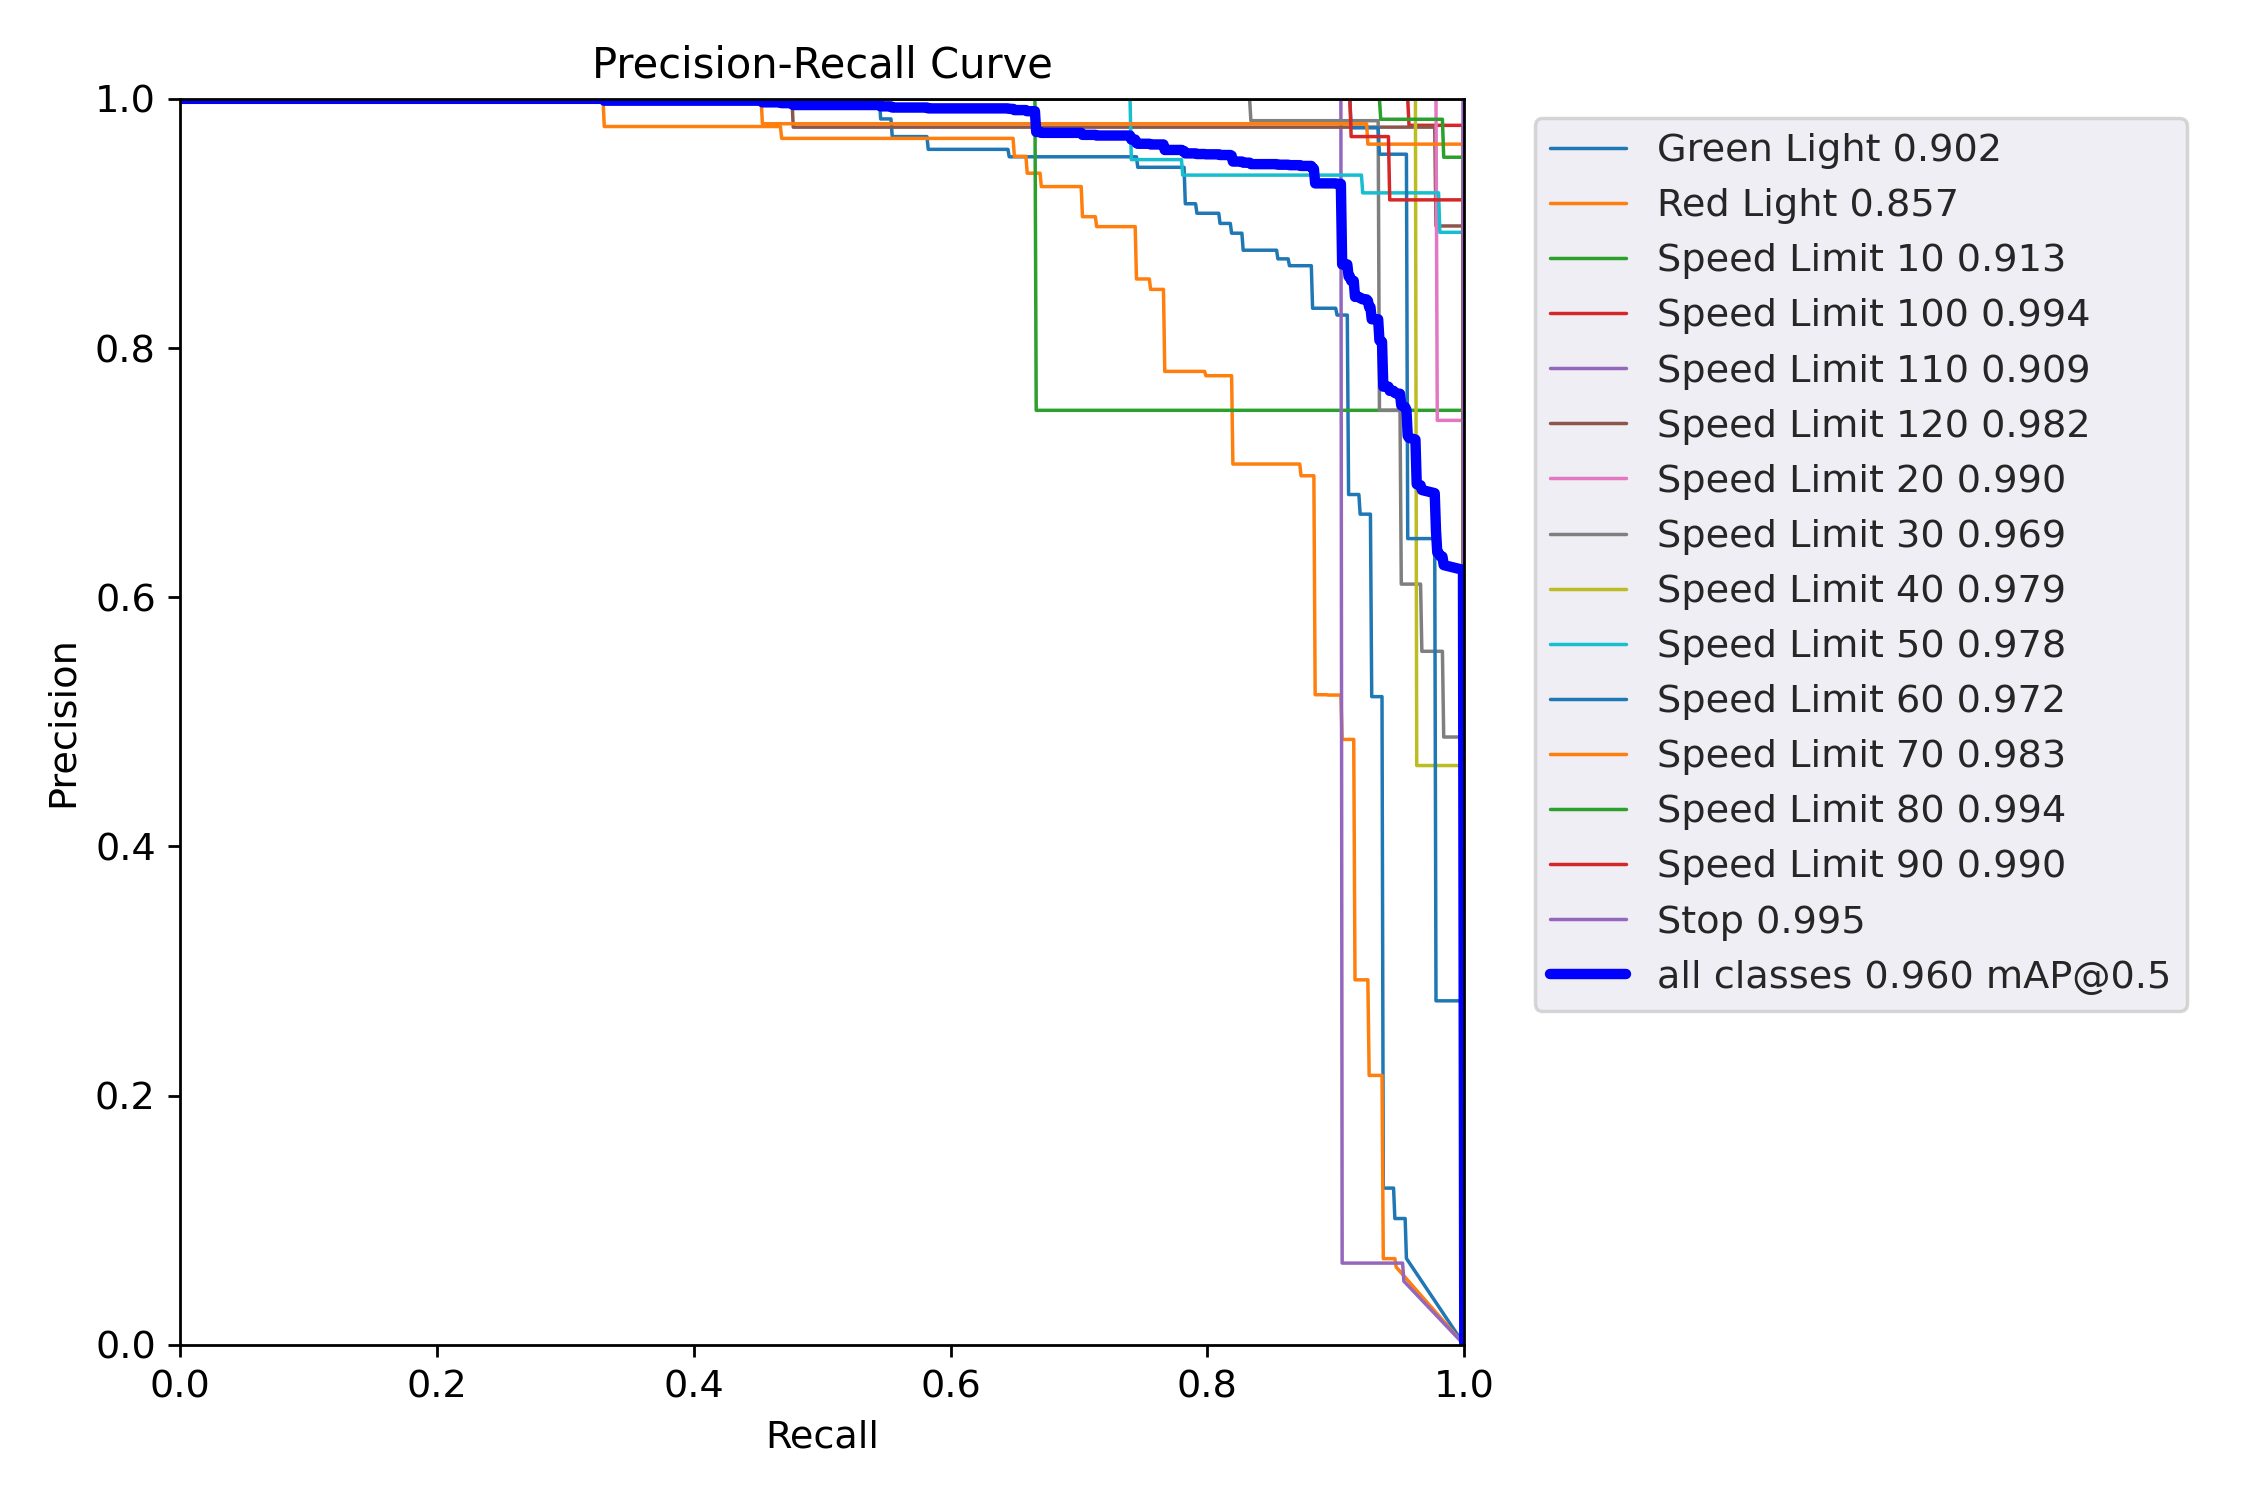


P_curve.png found at: runs/test/traffic_eval/P_curve.png


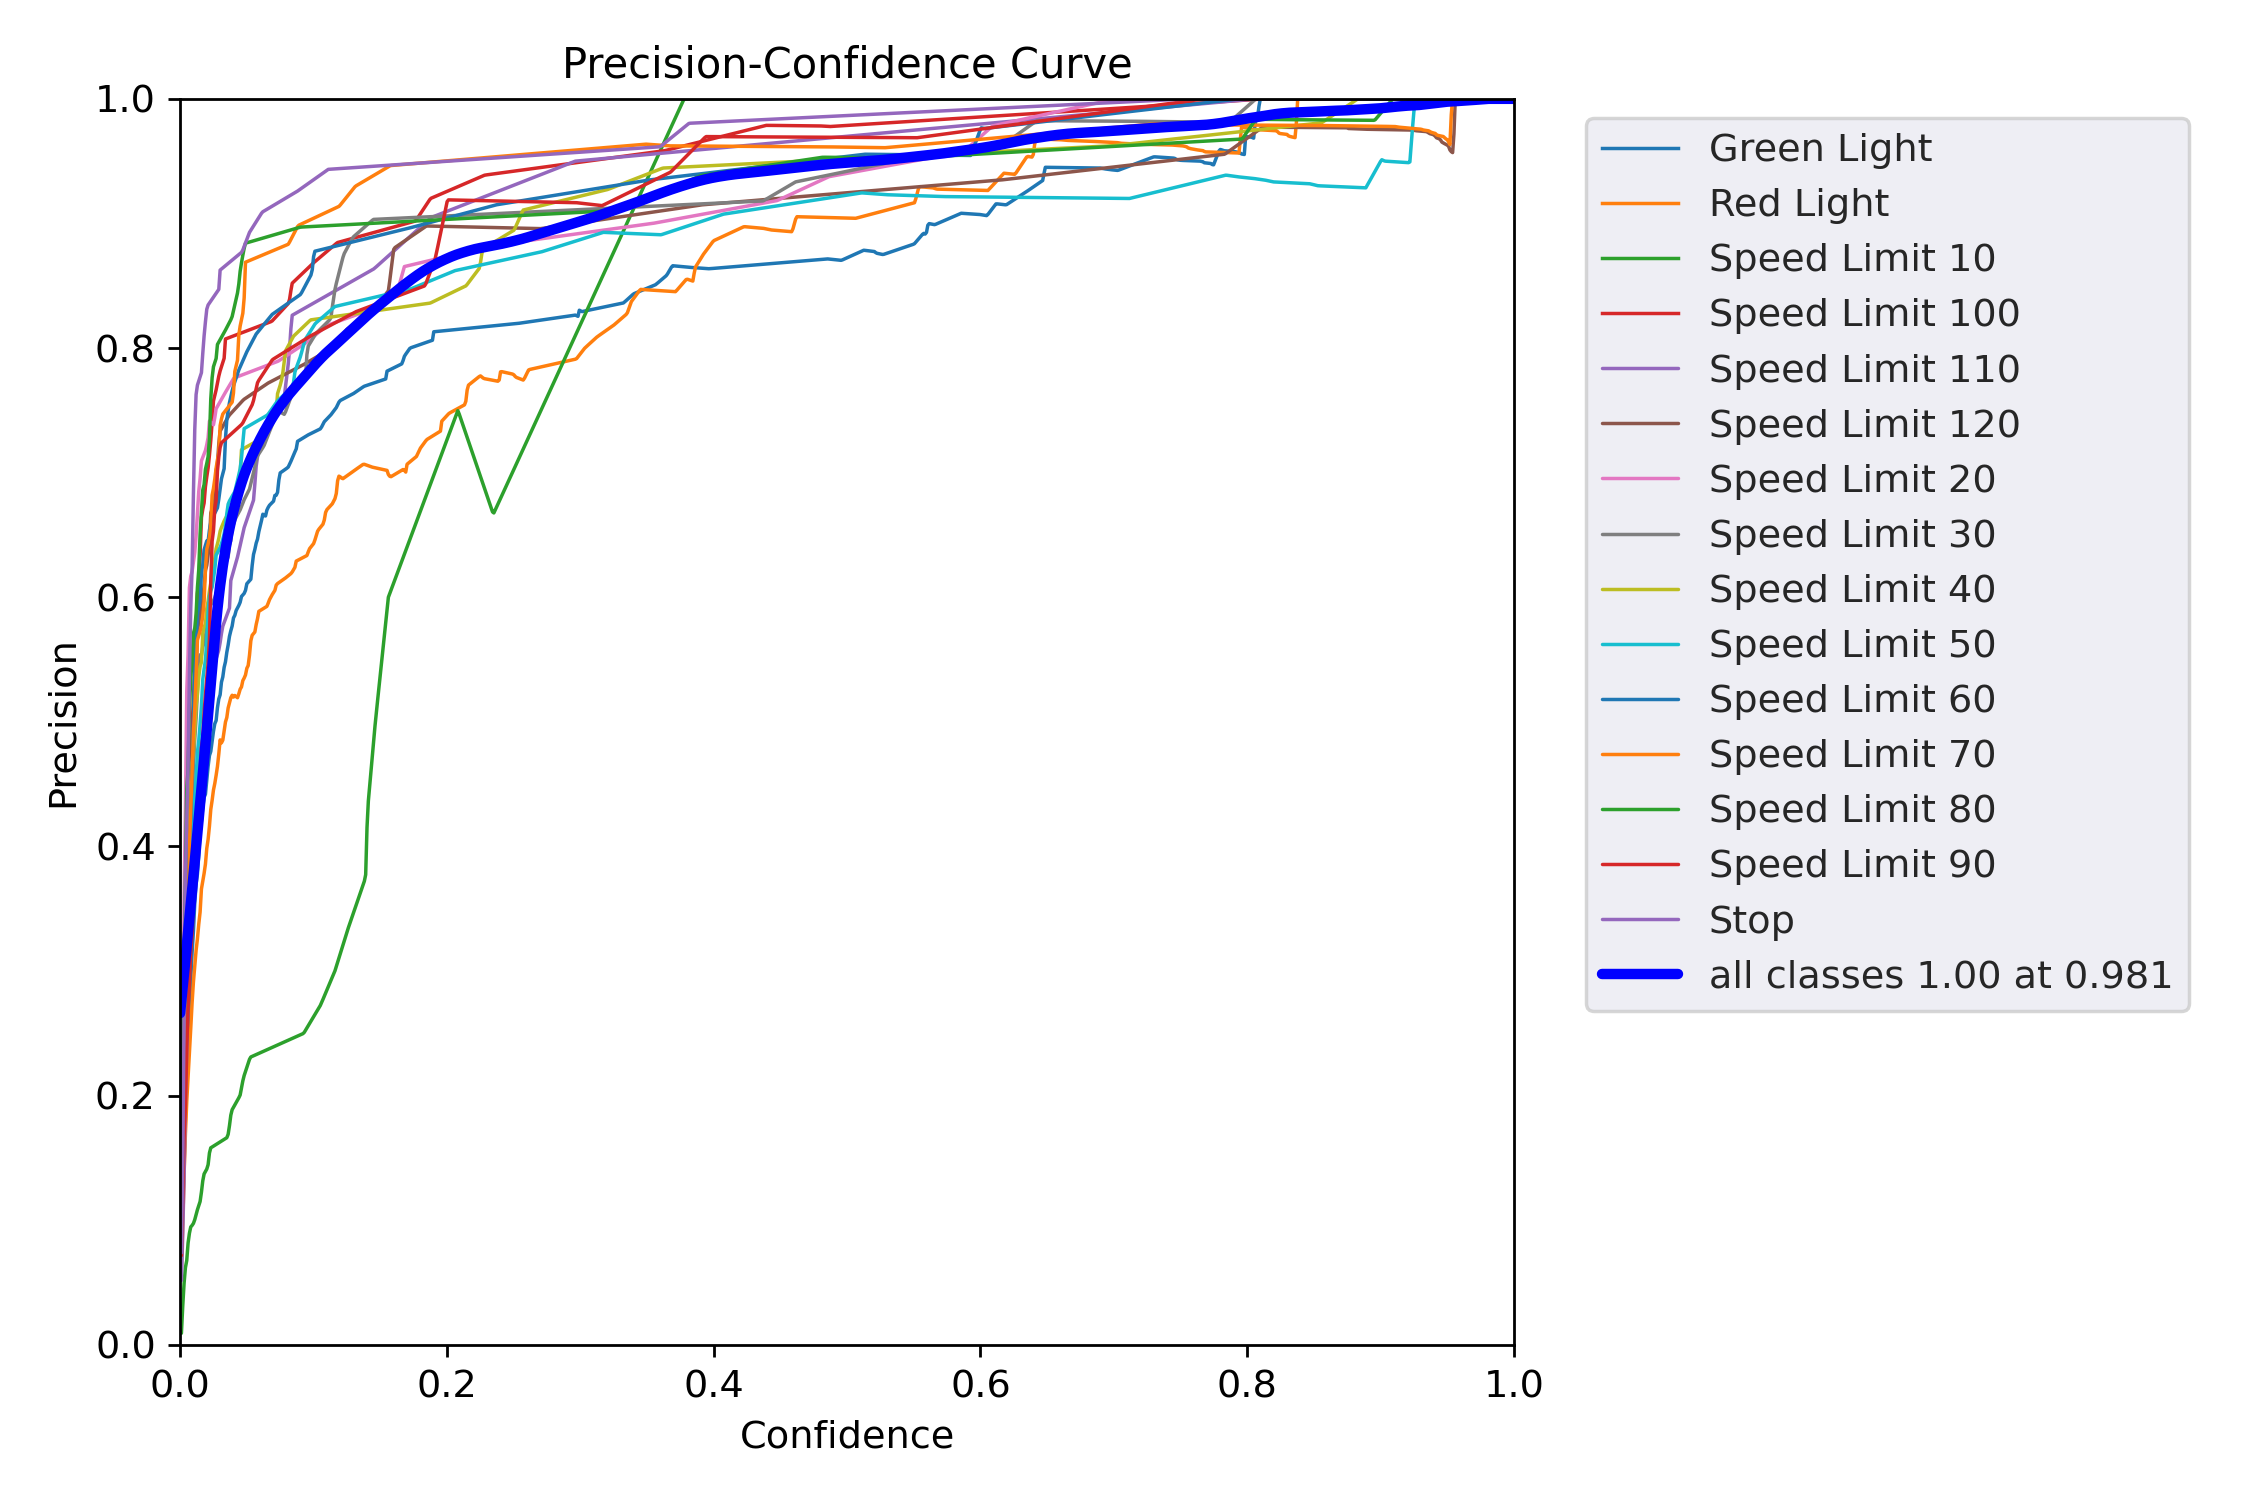


R_curve.png found at: runs/test/traffic_eval/R_curve.png


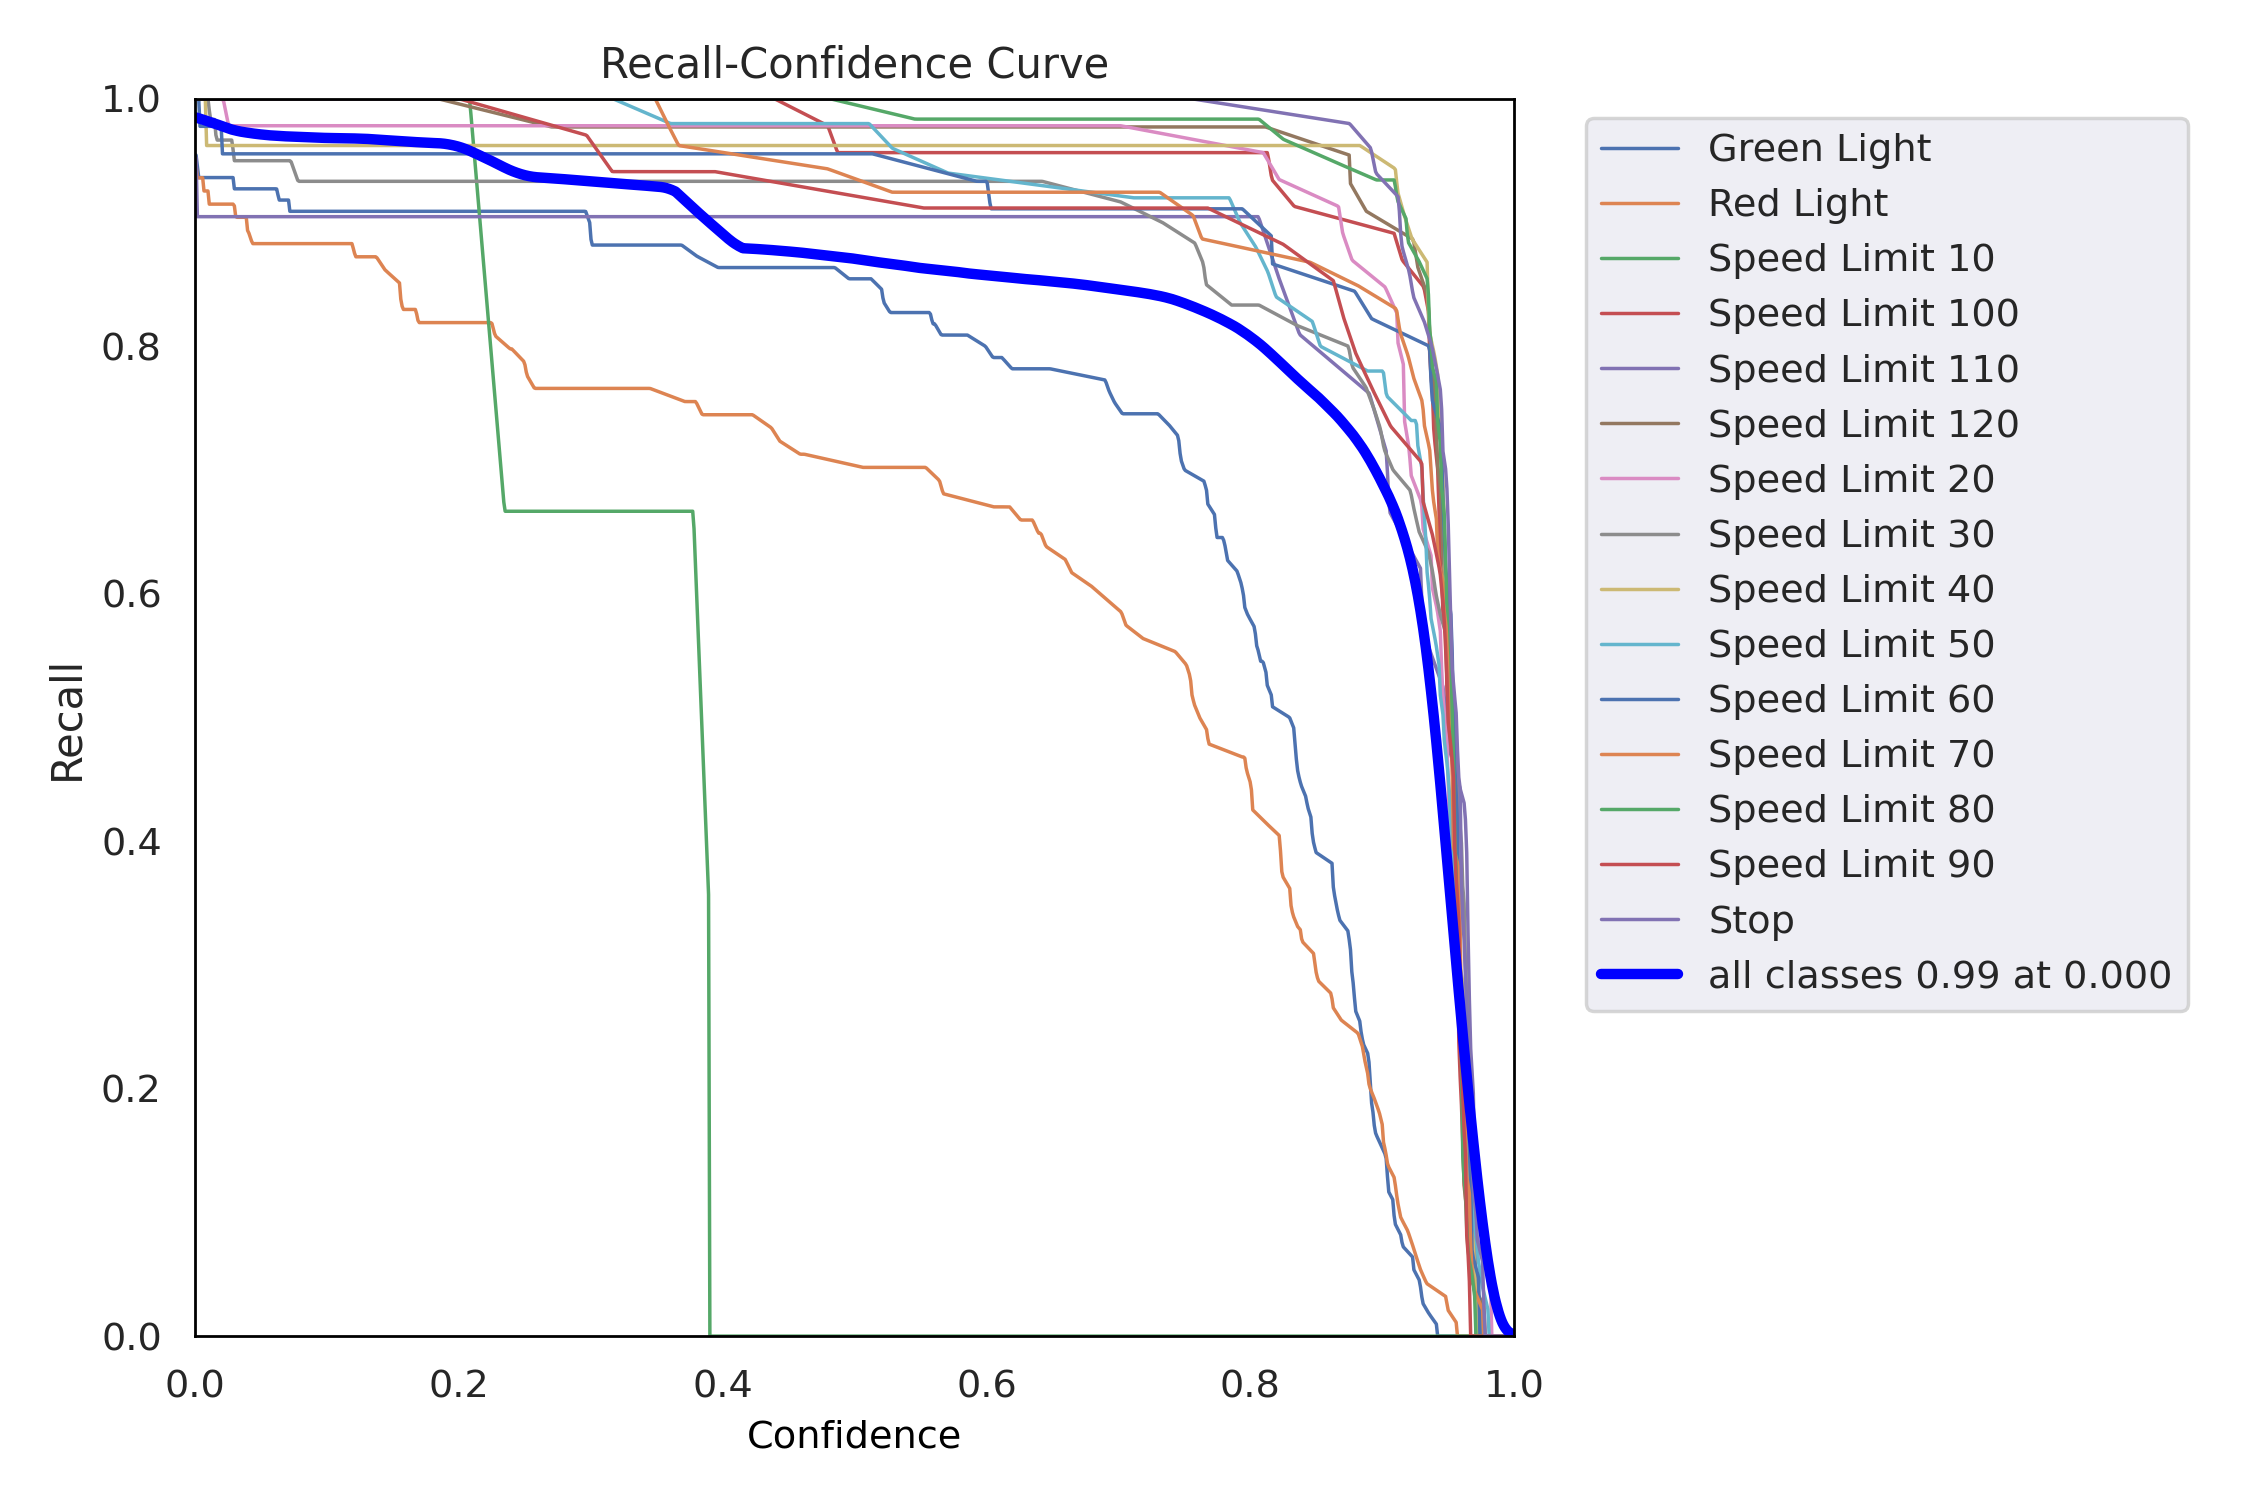


✅ PHASE 3 COMPLETE - Evaluation Done!


In [16]:
# CELL 12: DISPLAY EVALUATION RESULTS
# ==============================================================================

try:
    from IPython.display import Image, display
    in_notebook = True
except:
    in_notebook = False

eval_path = Path('runs/test/traffic_eval')

if eval_path.exists():
    print("\n" + "="*60)
    print("EVALUATION VISUALIZATIONS")
    print("="*60)

    eval_images = ['confusion_matrix.png', 'F1_curve.png', 'PR_curve.png',
                   'P_curve.png', 'R_curve.png']

    for img_name in eval_images:
        img_path = eval_path / img_name
        if img_path.exists():
            print(f"\n{img_name} found at: {img_path}")
            if in_notebook:
                display(Image(filename=str(img_path), width=900))

    # Parse metrics
    results_file = eval_path / 'results.csv'

    if results_file.exists():
        results_df = pd.read_csv(results_file)
        results_df.columns = results_df.columns.str.strip()
        last_row = results_df.iloc[-1]

        print("\n" + "="*60)
        print("TEST SET METRICS")
        print("="*60)
        print(f"Precision:     {last_row.get('metrics/precision', 0):.4f}")
        print(f"Recall:        {last_row.get('metrics/recall', 0):.4f}")

        map50 = last_row.get('metrics/mAP_0.5', last_row.get('metrics/mAP50', 0))
        map50_95 = last_row.get('metrics/mAP_0.5:0.95', last_row.get('metrics/mAP50-95', 0))

        print(f"mAP@0.5:       {map50:.4f}")
        print(f"mAP@0.5:0.95:  {map50_95:.4f}")
        print("="*60)
else:
    print("Evaluation results not found. Please run evaluation first.")

print("\n✅ PHASE 3 COMPLETE - Evaluation Done!")

In [17]:
# CELL 13: RUN INFERENCE ON TEST IMAGES
# ==============================================================================

import torch
import numpy as np

if best_weights.exists():
    print("="*60)
    print("LOADING MODEL FOR INFERENCE")
    print("="*60)

    model = torch.hub.load('ultralytics/yolov5', 'custom', path=str(best_weights))
    model.conf = 0.5  # Confidence threshold
    model.iou = 0.45  # IoU threshold for NMS

    print("✓ Model loaded successfully")
    print(f"  Confidence threshold: {model.conf}")
    print(f"  IoU threshold: {model.iou}")

    # Get test images
    test_imgs = list(Path(base / 'test' / 'images').glob('*.jpg'))
    if len(test_imgs) == 0:
        test_imgs = list(Path(base / 'test' / 'images').glob('*.png'))

    test_imgs = test_imgs[:9]  # First 9 images

    if len(test_imgs) > 0:
        print(f"\nProcessing {len(test_imgs)} test images...")

        fig, axes = plt.subplots(3, 3, figsize=(20, 20))
        axes = axes.flatten()

        for idx, img_path in enumerate(test_imgs):
            # Run inference
            results = model(str(img_path))

            # Render results
            img = np.array(results.render()[0])

            # Display
            axes[idx].imshow(img)
            axes[idx].set_title(img_path.name, fontsize=10)
            axes[idx].axis('off')

        plt.tight_layout()
        plt.savefig('test_predictions.png', dpi=150, bbox_inches='tight')
        plt.show()

        print("✓ Predictions visualized and saved to test_predictions.png")
    else:
        print("No test images found!")
else:
    print("Model weights not found. Please run training first.")

print("\n✅ PHASE 4 COMPLETE - Inference Done!")


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-12-14 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)

Fusing layers... 


LOADING MODEL FOR INFERENCE


Model summary: 157 layers, 7050580 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.

✓ Model loaded successfully
  Confidence threshold: 0.5
  IoU threshold: 0.45

Processing 9 test images...
✓ Predictions visualized and saved to test_predictions.png

✅ PHASE 4 COMPLETE - Inference Done!


In [14]:
# CELL 14: INFERENCE SPEED BENCHMARK (OPTIONAL)
# ==============================================================================

import time

if best_weights.exists() and len(test_imgs) > 0:
    print("\n" + "="*60)
    print("INFERENCE SPEED BENCHMARK")
    print("="*60)

    test_img = str(test_imgs[0])

    # Warmup
    for _ in range(10):
        _ = model(test_img)

    # Measure inference time
    times = []
    for _ in range(100):
        start = time.time()
        _ = model(test_img)
        times.append((time.time() - start) * 1000)  # Convert to ms

    print(f"Inference Speed (100 iterations):")
    print(f"  Mean:   {np.mean(times):.2f} ms/image")
    print(f"  Std:    {np.std(times):.2f} ms")
    print(f"  Min:    {np.min(times):.2f} ms")
    print(f"  Max:    {np.max(times):.2f} ms")
    print(f"  FPS:    {1000/np.mean(times):.1f}")
    print("="*60)



INFERENCE SPEED BENCHMARK


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.am

Inference Speed (100 iterations):
  Mean:   11.44 ms/image
  Std:    0.41 ms
  Min:    11.08 ms
  Max:    13.50 ms
  FPS:    87.4


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [15]:
# CELL 15: SUMMARY AND NEXT STEPS
# ==============================================================================

print("\n" + "="*80)
print("🎉 COMPLETE YOLOV5 TRAFFIC DETECTION PIPELINE FINISHED!")
print("="*80)

print("\nPipeline Summary:")
print("  ✓ Dataset prepared and analyzed")
print("  ✓ YOLOv5 model trained")
print("  ✓ Model evaluated on test set")
print("  ✓ Inference completed")

print("\nGenerated Files:")
print("  - traffic_data.yaml (dataset configuration)")
print("  - sample_visualizations.png (sample images)")
print("  - class_distribution.png (class analysis)")
print("  - runs/train/traffic_yolov5s_exp/ (training results)")
print("  - runs/test/traffic_eval/ (evaluation results)")
print("  - test_predictions.png (inference results)")

print("\nNext Steps:")
print("  1. For better accuracy, retrain with 40-60 epochs")
print("  2. Try different image sizes (512, 640, 800)")
print("  3. Experiment with YOLOv5m or YOLOv5l for higher accuracy")
print("  4. Test on real-world traffic videos")
print("  5. Deploy to edge devices for real-time detection")

print("\n" + "="*80)
print("✅ ALL PHASES COMPLETED SUCCESSFULLY!")
print("="*80)



🎉 COMPLETE YOLOV5 TRAFFIC DETECTION PIPELINE FINISHED!

Pipeline Summary:
  ✓ Dataset prepared and analyzed
  ✓ YOLOv5 model trained
  ✓ Model evaluated on test set
  ✓ Inference completed

Generated Files:
  - traffic_data.yaml (dataset configuration)
  - sample_visualizations.png (sample images)
  - class_distribution.png (class analysis)
  - runs/train/traffic_yolov5s_exp/ (training results)
  - runs/test/traffic_eval/ (evaluation results)
  - test_predictions.png (inference results)

Next Steps:
  1. For better accuracy, retrain with 40-60 epochs
  2. Try different image sizes (512, 640, 800)
  3. Experiment with YOLOv5m or YOLOv5l for higher accuracy
  4. Test on real-world traffic videos
  5. Deploy to edge devices for real-time detection

✅ ALL PHASES COMPLETED SUCCESSFULLY!
